<a href="https://colab.research.google.com/github/LEE-1017/Gener--AI/blob/main/HW10_NTNU%E6%95%B8114%E6%9D%8E%E6%B5%A9%E6%8F%9A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install diffusers transformers accelerate safetensors huggingface_hub gradio --upgrade

In [ ]:
from google.colab import userdata
from huggingface_hub import login
hf_token = userdata.get("HuggingFace")
login(token=hf_token)

In [ ]:
from diffusers import StableDiffusionPipeline, UniPCMultistepScheduler
import torch
import gc
import matplotlib.pyplot as plt
import gradio as gr
import random

# 注意!!!!!這裡是從雲端讀模型，下載連結在這:https://civitai.com/models/66/anything-v3

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
model_name = "ckpt/anything-v4.0"

注意有可能要停用 `use_safetensors=True`。

In [ ]:
from diffusers import StableDiffusionPipeline
import torch

model_path = "/content/drive/MyDrive/sd_models/anythingV3_fp16.safetensors"

pipe = StableDiffusionPipeline.from_single_file(
    model_path,
    torch_dtype=torch.float16,
    use_safetensors=True
).to("cuda")

In [ ]:
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

In [ ]:
def generate_images(prompt, use_enhance, enhance_text, use_negative, negative_text,
                    use_custom_seed, custom_seed, height, width, steps, num_images):

    height = int(height)
    width = int(width)

    if height % 8 != 0 or width % 8 != 0:
        raise ValueError("高度和寬度必須是8的倍數！")

    if use_custom_seed:
        base_seed = int(custom_seed)
    else:
        base_seed = random.randint(0, 2**32 - 1)

    seeds = [base_seed + i for i in range(num_images)]

    prompts = []
    negative_prompts = []
    generators = []

    final_prompt = prompt
    if use_enhance and enhance_text:
        final_prompt = prompt + ", " + enhance_text

    final_negative = negative_text if use_negative else None

    for seed in seeds:
        g = torch.Generator("cuda").manual_seed(seed)
        generators.append(g)
        prompts.append(final_prompt)
        negative_prompts.append(final_negative)

    gc.collect()
    torch.cuda.empty_cache()

    images = []
    for i in range(num_images):
        with torch.no_grad():
            image = pipe(
                prompt=prompts[i],
                negative_prompt=negative_prompts[i] if final_negative else None,
                height=height,
                width=width,
                num_inference_steps=steps,
                guidance_scale=7.5,
                generator=generators[i]
            ).images[0]
            images.append(image)

    return images, f"使用的 random seeds: {seeds}"

In [ ]:
default_enhance = (
    "masterpiece, best quality, anime screencap, high resolution, "
    "detailed eyes, perfect anatomy, beautiful skin,"
)

default_negative = ("bad anatomy, blurry, disfigured, poorly drawn hands, extra fingers, mutated hands, low quality, worst quality"
)

In [ ]:


with gr.Blocks(css=".gradio-container {background-color: #FAFAFA; padding: 20px;} .gr-button {font-size: 18px; background: linear-gradient(to right, #667eea, #764ba2); color: white;}") as demo:
    gr.Markdown("""
    # 二次元天堂圖像生成器
    歡迎使用！輸入提示詞、選擇設定，立即生成！
    """)

    with gr.Row():
        with gr.Column(scale=6):
            prompt = gr.Textbox(label="Prompt", placeholder="請輸入你的提示詞 (prompt)", lines=3)
            with gr.Row():
                use_enhance = gr.Checkbox(label="加強 Prompt", value=True)
                enhance_text = gr.Textbox(label="加強內容", value=default_enhance)
            with gr.Row():
                use_negative = gr.Checkbox(label="使用 Negative Prompt", value=True)
                negative_text = gr.Textbox(label="Negative Prompt 內容", value=default_negative)
            with gr.Row():
                use_custom_seed = gr.Checkbox(label="自訂 Random Seed", value=False)
                custom_seed = gr.Number(label="指定 seed (選填)", value=42)
            with gr.Row():
                height = gr.Dropdown(["512", "768", "1024"], label="高度 Height", value="512")
                width = gr.Dropdown(["512", "768", "1024"], label="寬度 Width", value="512")
            with gr.Row():
                steps = gr.Slider(10, 50, value=40, step=5, label="生成步數 (Steps)")
                num_images = gr.Slider(1, 4, step=1, value=1, label="生成張數")
            generate_btn = gr.Button("🚀 開始生成！")

        with gr.Column(scale=6):
            gallery = gr.Gallery(label="生成結果", columns=2, object_fit="contain", height="auto")
            seed_info = gr.Label(label="使用的 Random Seeds")

    generate_btn.click(
        fn=generate_images,
        inputs=[prompt, use_enhance, enhance_text, use_negative, negative_text,
                use_custom_seed, custom_seed, height, width, steps, num_images],
        outputs=[gallery, seed_info]
    )

In [ ]:
demo.launch(share=True, debug=True)



---



以下是我的結果，第一組prompt:1girl,face viewer,sexy,bunny girl,bare feet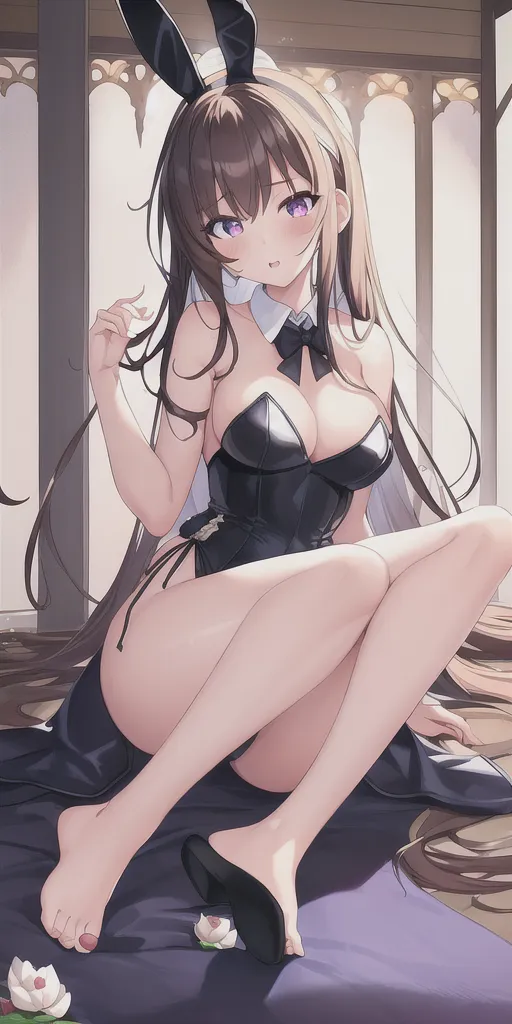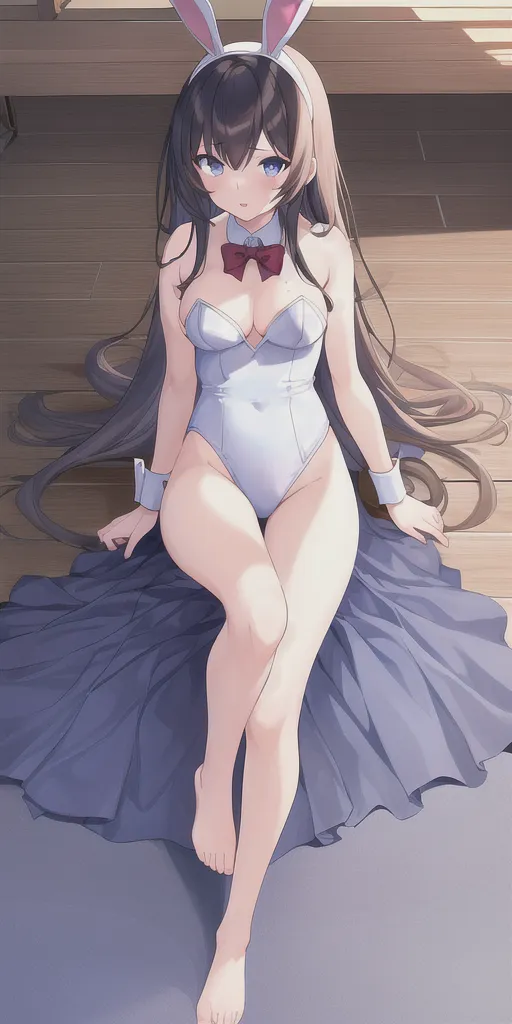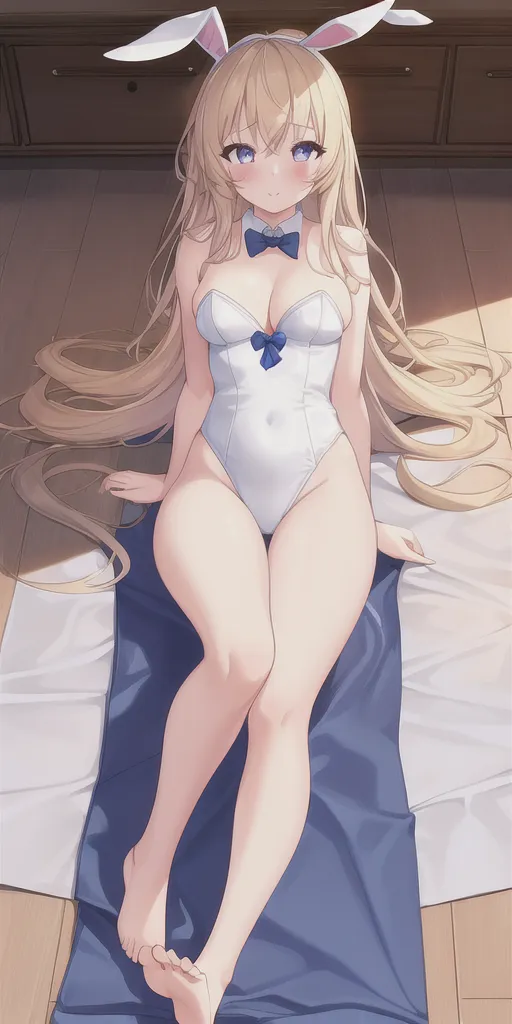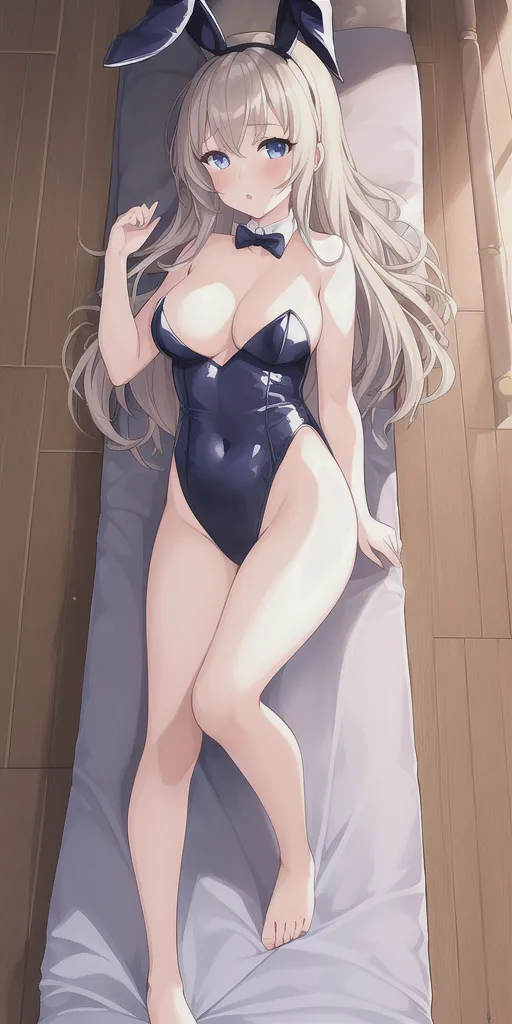

第2組prompt:1girl,face viewer,sexy,sweat,bare feet,student


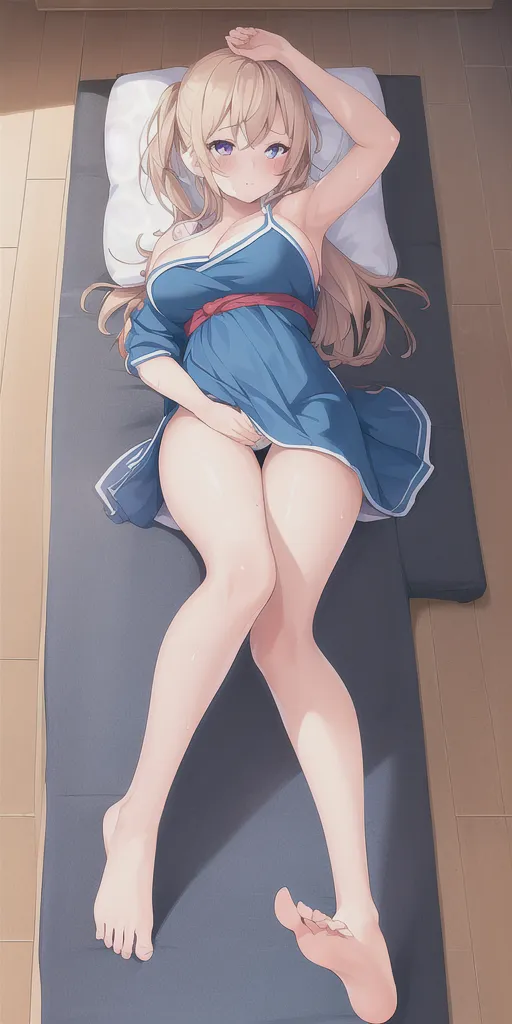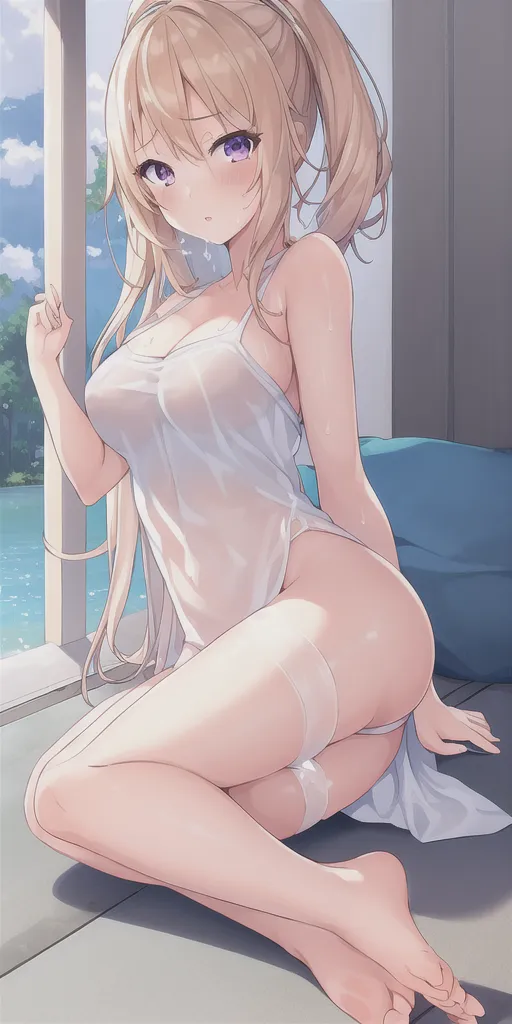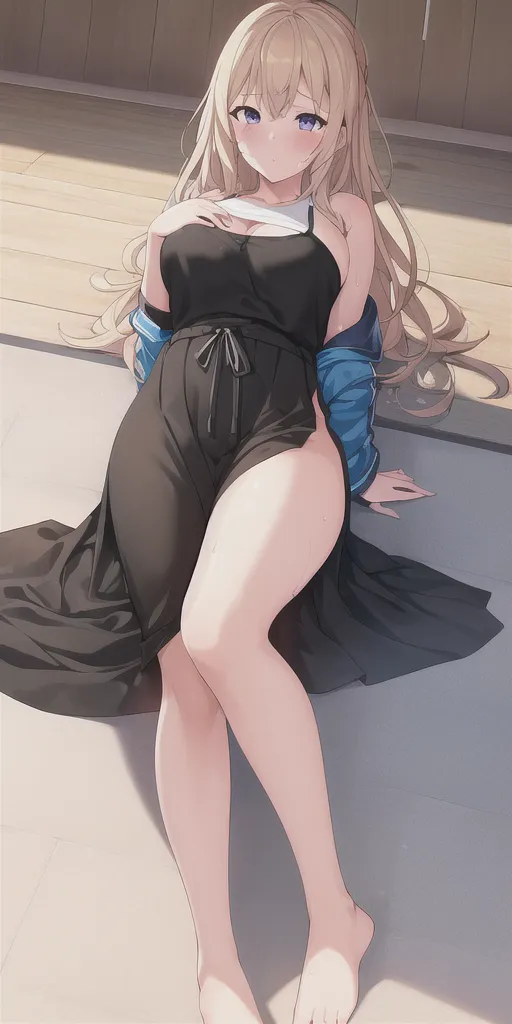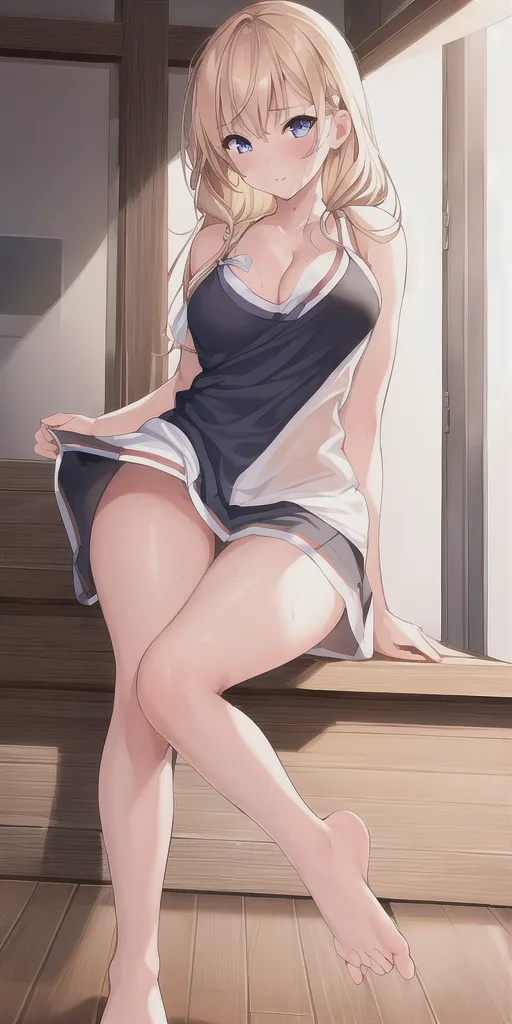